#### 1. Можно ли отобрать наиболее значимые признаки с помощью PCA?

Да, в этом же и суть метода.

#### 3*. Написать свою реализацию метода главных компонент с помощью сингулярного разложения с использованием функции numpy.linalg.svd()

In [1]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt

In [2]:
# Загрузим игрушечный датасет из sklearn
iris = datasets.load_iris()
X = iris.data
X.shape

(150, 4)

In [3]:
# Для начала отмасштабируем выборку
X_ = X.astype(float)

rows, cols = X_.shape

# центрирование - вычитание из каждого значения среднего по строке
means = X_.mean(0)
for i in range(rows):
    for j in range(cols):
        X_[i, j] -= means[j]

# деление каждого значения на стандартное отклонение
std = np.std(X_, axis=0)
for i in range(cols):
    for j in range(rows):
        X_[j][i] /= std[i]

In [4]:
u, D, vh = np.linalg.svd(X_)

In [5]:
print(D)

[20.92306556 11.7091661   4.69185798  1.76273239]


In [6]:
svd_pairs = [(np.abs(D[i]), vh[:, i]) for i in range(len(D))]

# и отсортируем список по убыванию собственных значений
svd_pairs.sort(key=lambda x: x[0], reverse=True)
svd_pairs

[(20.923065561236466,
  array([ 0.52106591, -0.37741762,  0.71956635,  0.26128628])),
 (11.70916609841241,
  array([-0.26934744, -0.92329566, -0.24438178, -0.12350962])),
 (4.69185798332572,
  array([ 0.5804131 , -0.02449161, -0.14212637, -0.80144925])),
 (1.7627323858977801,
  array([ 0.56485654, -0.06694199, -0.63427274,  0.52359713]))]

In [7]:
sig_val_sum = sum(D)
var_exp = [(i / sig_val_sum) * 100 for i in D]
cum_var_exp = np.cumsum(var_exp)
print(f'Доля дисперсии, описвыаемая каждой из компонент \n{var_exp}')

# а теперя оценим кумулятивную (то есть накапливаемую) дисперсию при учитывании каждой из компонент
print(f'Кумулятивная доля дисперсии по компонентам \n{cum_var_exp}')

Доля дисперсии, описвыаемая каждой из компонент 
[53.52971788236241, 29.956812784020066, 12.003682417209491, 4.509786916408035]
Кумулятивная доля дисперсии по компонентам 
[ 53.52971788  83.48653067  95.49021308 100.        ]


In [8]:
W = np.hstack((svd_pairs[0][1].reshape(4,1), svd_pairs[1][1].reshape(4,1), svd_pairs[2][1].reshape(4,1)))

print(f'Матрица весов W:\n', W)

Матрица весов W:
 [[ 0.52106591 -0.26934744  0.5804131 ]
 [-0.37741762 -0.92329566 -0.02449161]
 [ 0.71956635 -0.24438178 -0.14212637]
 [ 0.26128628 -0.12350962 -0.80144925]]


In [9]:
Z = X_.dot(W)

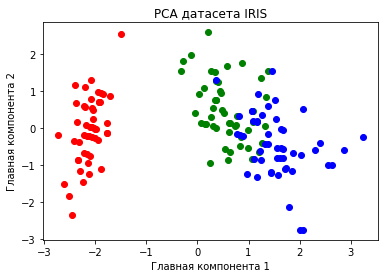

In [10]:
plt.figure()
y = iris.target
for c, i in zip("rgb", [0, 1, 2]):
    plt.scatter(Z[y==i, 0], Z[y==i, 1], c=c)
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.title('PCA датасета IRIS')
plt.show()

#### 4*. Обучить любую модель классификации на датасете iris до применения PCA и после него. Сравнить качество классификации по отложенной выборке.

In [11]:
from tqdm import tqdm
import numpy as np
from sklearn import model_selection
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

In [12]:
X, y = load_iris(return_X_y=True)

In [13]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.35, random_state=1)

In [14]:
def e_metrics(x1, x2):
    
    distance = 0
    for i in range(len(x1)):
        distance += np.square(x1[i] - x2[i])
    
    return np.sqrt(distance)

In [15]:
# Расчёт веса через номер соседа: 
# w_i = (k - i + 1)/k

def knn(x_train, y_train, x_test, k):
    
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))
        
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Инициализируем вектор весов для k соседей
        W = [(k - i + 1)/k for i in range(k)]
        
        # Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
        
        for i, d in enumerate(sorted(test_distances)[0:k]):
            classes[d[1]] += W[i]
            
        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(sorted(classes, key=classes.get)[-1])
    return answers

In [16]:
def accuracy(pred, y):
    return (sum(pred == y) / len(y))

In [23]:
k = 5

y_pred = knn(X_train, y_train, X_test, k)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 5: 0.962


In [24]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(Z, y, test_size=0.35, 
                                                                    random_state=1)

In [25]:
k = 5

y_pred = knn(X_train, y_train, X_test, k)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 5: 0.962
